In [ ]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imutils import build_montages

In [ ]:
dataset_dir = '/content/drive/My Drive/Datasets/numbers'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")
testing2Path = os.path.join(dataset_dir, "testing2")

In [ ]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)

		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding

		return image

In [ ]:
def preprocess2(image, image_size=28):
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale

  height, width = image.shape[:2]

  if height != image_size or width !=image_size:
    image = cv.resize(image, (image_size, image_size))
  
  image = cv.threshold(image, 0, 255, cv.THRESH_OTSU)[1]

  image = image.flatten()

  image = image / 255.0
  
  return image

In [ ]:
def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

	return features

In [ ]:
def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")

  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))

  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)

  return hist

In [ ]:
def load_split(path, image_size=200, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)

		data.append(features)
		labels.append(label)

	return (np.array(data), np.array(labels))

load split menggunakan preprocess2

In [ ]:
def load_split2(path, image_size=200, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess2(image, image_size=image_size)
		
		# if extraction_method == 'hog':
		# 	features = quantify_image_hog(image)
		# elif extraction_method == 'lbp':
		# 	features = quantify_image_lbp(image)

		data.append(image)
		labels.append(label)

	return (np.array(data), np.array(labels))

In [ ]:
resize_image_size = 28 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap
extraction_method = 'hog' # 'lbp' atau 'hog'

Model Menggunakan preprocess

In [ ]:
def model_train(resize_image_size, extraction_method, estimator):
  (feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
  (feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)
  # (feature_test, label_test) = load_split(testing2Path, image_size=resize_image_size, extraction_method=extraction_method)
  # print("Data loaded!")

  le = LabelEncoder()
  label_train = le.fit_transform(label_train)
  label_test = le.transform(label_test)

  #LOGISTIC REGRESSION
  logreg = LogisticRegression()
  logreg.fit(feature_train, label_train)
  predictions = logreg.predict(feature_test)

  print('Logistic Regression')
  print('Akurasi dari Testing Set: {:.3f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
  print("f1 score ", f1_score(label_test, predictions, average='macro'))
  print("precision score ", precision_score(label_test, predictions, average='macro'))
  print("recall score ", recall_score(label_test, predictions, average='macro'))
  print()

  #LinearSVC 
  classifier_linear_svc = SVC()
  classifier_linear_svc.fit(feature_train, label_train)
  predictions = classifier_linear_svc.predict(feature_test)

  print('LinearSVC')
  print('Akurasi dari Testing Set: {:.3f}'.format(classifier_linear_svc.score(feature_test, label_test))) # .score() -> Accuracy
  print("f1 score ", f1_score(label_test, predictions, average='macro'))
  print("precision score ", precision_score(label_test, predictions, average='macro'))
  print("recall score ", recall_score(label_test, predictions, average='macro'))
  print()

  #RANDOM FOREST
  random_forest = RandomForestClassifier(n_estimators=estimator, random_state=10)
  random_forest.fit(feature_train, label_train)
  predictions = random_forest.predict(feature_test)

  print('Random Forest Classifier')
  print('Akurasi dari Testing Set: {:.3f}'.format(random_forest.score(feature_test, label_test))) # .score() -> Accuracy
  print("f1 score ", f1_score(label_test, predictions, average='macro'))
  print("precision score ", precision_score(label_test, predictions, average='macro'))
  print("recall score ", recall_score(label_test, predictions, average='macro'))
  print()


In [ ]:
model_train(128, 'hog', 500)

Logistic Regression
Akurasi dari Testing Set: 0.992
f1 score  0.9922256173117968
precision score  0.9922839980214521
recall score  0.9922259136212624

LinearSVC
Akurasi dari Testing Set: 0.996
f1 score  0.9955592376953107
precision score  0.9955665561683414
recall score  0.9955629383536361

Random Forest Classifier
Akurasi dari Testing Set: 0.996
f1 score  0.9955573396334576
precision score  0.9955811017343345
recall score  0.9955592469545959



In [ ]:
model_train(128, 'lbp', 500)

Logistic Regression
Akurasi dari Testing Set: 0.713
f1 score  0.6645636735029561
precision score  0.8100273741006007
recall score  0.7122259136212624

LinearSVC
Akurasi dari Testing Set: 0.866
f1 score  0.8636042194763632
precision score  0.8758852196534658
recall score  0.8655592469545957

Random Forest Classifier
Akurasi dari Testing Set: 0.968
f1 score  0.967725743706016
precision score  0.9685280187378872
recall score  0.967781469176818



Untuk hasil akurasi dari model nya sudah sangat bagus dengan menggunakan image size 128, feature extraction method HOG didapatkan nilai akurasi 0.99

In [ ]:
testing_paths = list(paths.list_images(testingPath))
images = []

(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)
# (feature_test, label_test) = load_split(testing2Path, image_size=resize_image_size, extraction_method=extraction_method)

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

random_forest = RandomForestClassifier(n_estimators=500, random_state=10)
random_forest.fit(feature_train, label_train)
# predictions = random_forest.predict(feature_test)

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=128)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = random_forest.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "0" else (0, 0, 255) if label == "1" else (0, 225, 225)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

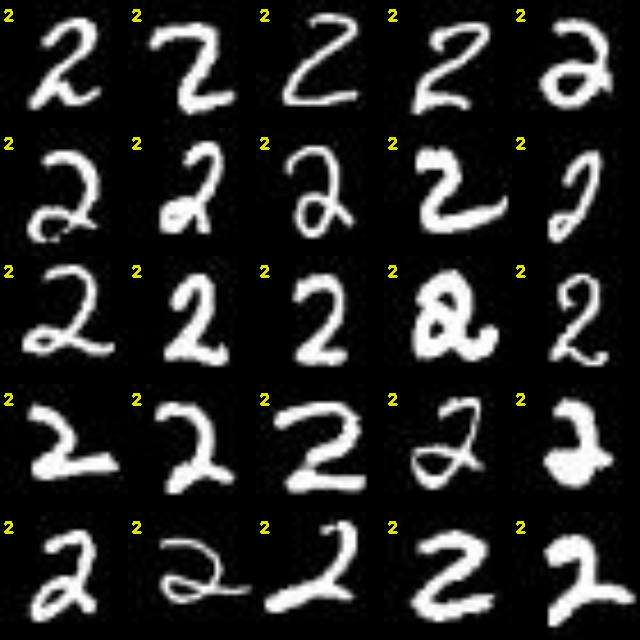

In [ ]:
montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

In [ ]:
image_test = cv.imread('/content/drive/My Drive/Datasets/numbers/training/1/img_1000.jpg')

image_test_preprocessed = preprocess2(image_test, image_size=28)

print(image_test_preprocessed)

cv2_imshow(image_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.

Model Menggunakan Preprocess2

In [ ]:
def model_train2(resize_image_size, estimator):
  (feature_train, label_train) = load_split2(trainingPath, image_size=resize_image_size)#, extraction_method=extraction_method)
  (feature_test, label_test) = load_split2(testingPath, image_size=resize_image_size)#, extraction_method=extraction_method)
  # (feature_test, label_test) = load_split(testing2Path, image_size=resize_image_size, extraction_method=extraction_method)
  # print("Data loaded!")

  le = LabelEncoder()
  label_train = le.fit_transform(label_train)
  label_test = le.transform(label_test)

  #LOGISTIC REGRESSION
  logreg = LogisticRegression()
  logreg.fit(feature_train, label_train)
  predictions = logreg.predict(feature_test)

  print('Logistic Regression')
  print('Akurasi dari Testing Set: {:.3f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
  print("f1 score ", f1_score(label_test, predictions, average='macro'))
  print("precision score ", precision_score(label_test, predictions, average='macro'))
  print("recall score ", recall_score(label_test, predictions, average='macro'))
  print()

  #LinearSVC 
  classifier_linear_svc = SVC()
  classifier_linear_svc.fit(feature_train, label_train)
  predictions = classifier_linear_svc.predict(feature_test)

  print('LinearSVC')
  print('Akurasi dari Testing Set: {:.3f}'.format(classifier_linear_svc.score(feature_test, label_test))) # .score() -> Accuracy
  print("f1 score ", f1_score(label_test, predictions, average='macro'))
  print("precision score ", precision_score(label_test, predictions, average='macro'))
  print("recall score ", recall_score(label_test, predictions, average='macro'))
  print()

  #RANDOM FOREST
  random_forest = RandomForestClassifier(n_estimators=estimator, random_state=10)
  random_forest.fit(feature_train, label_train)
  predictions = random_forest.predict(feature_test)

  print('Random Forest Classifier')
  print('Akurasi dari Testing Set: {:.3f}'.format(random_forest.score(feature_test, label_test))) # .score() -> Accuracy
  print("f1 score ", f1_score(label_test, predictions, average='macro'))
  print("precision score ", precision_score(label_test, predictions, average='macro'))
  print("recall score ", recall_score(label_test, predictions, average='macro'))
  print()


In [ ]:
model_train2(128, 500)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression
Akurasi dari Testing Set: 0.978
f1 score  0.9777882235252889
precision score  0.9778341898517336
recall score  0.9777888519748985

LinearSVC
Akurasi dari Testing Set: 0.991
f1 score  0.9911148025101514
precision score  0.9911148025101514
recall score  0.9911148025101514

Random Forest Classifier
Akurasi dari Testing Set: 0.990
f1 score  0.9900147901645405
precision score  0.9900332225913621
recall score  0.9900073827980805



Data Testing Menggunakan Gambar sendiri

In [ ]:
image2 = cv.imread('/content/drive/My Drive/Datasets/newtest.jpg')

image2_orig = image2.copy()
cv2_imshow(image2_orig)

Output hidden; open in https://colab.research.google.com to view.

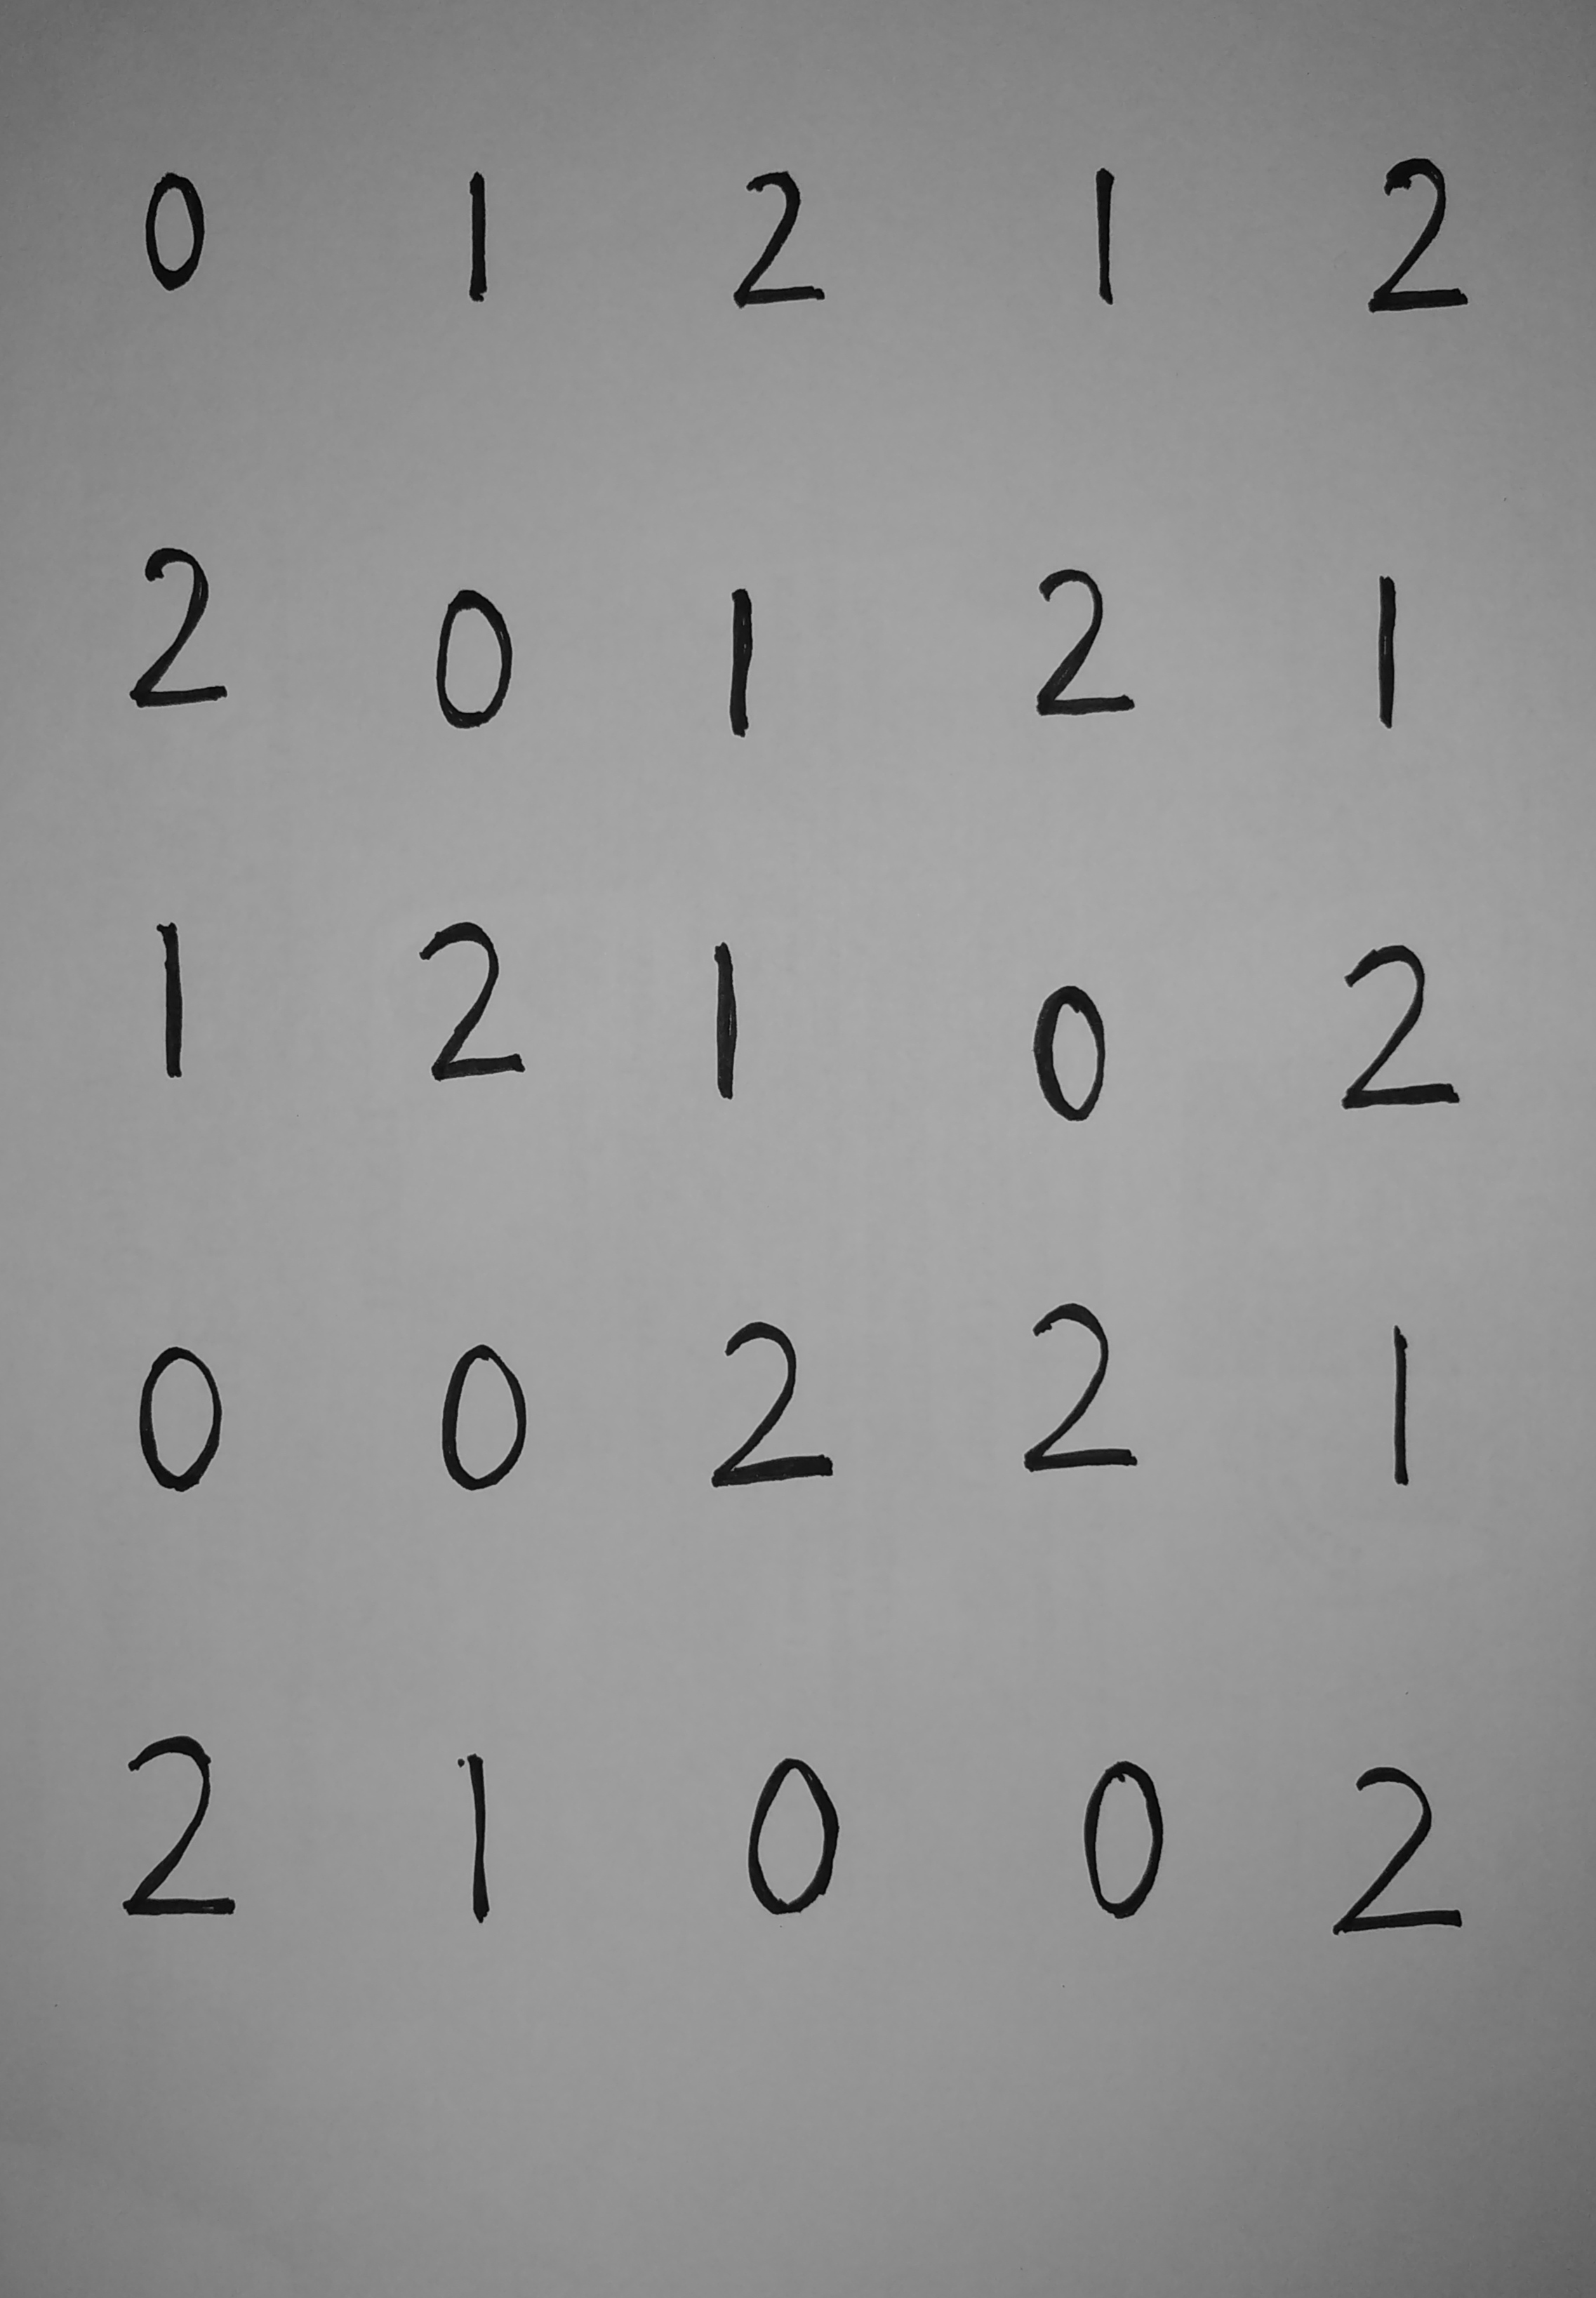

In [ ]:
image2_gray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
cv2_imshow(image2_gray)

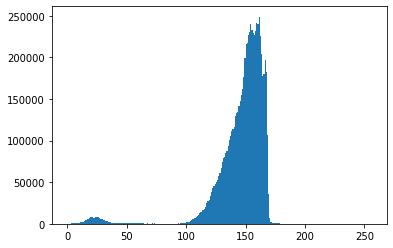

In [ ]:
plt.hist(image2_gray.flatten(), 256, [0,256])
plt.show()

100.0


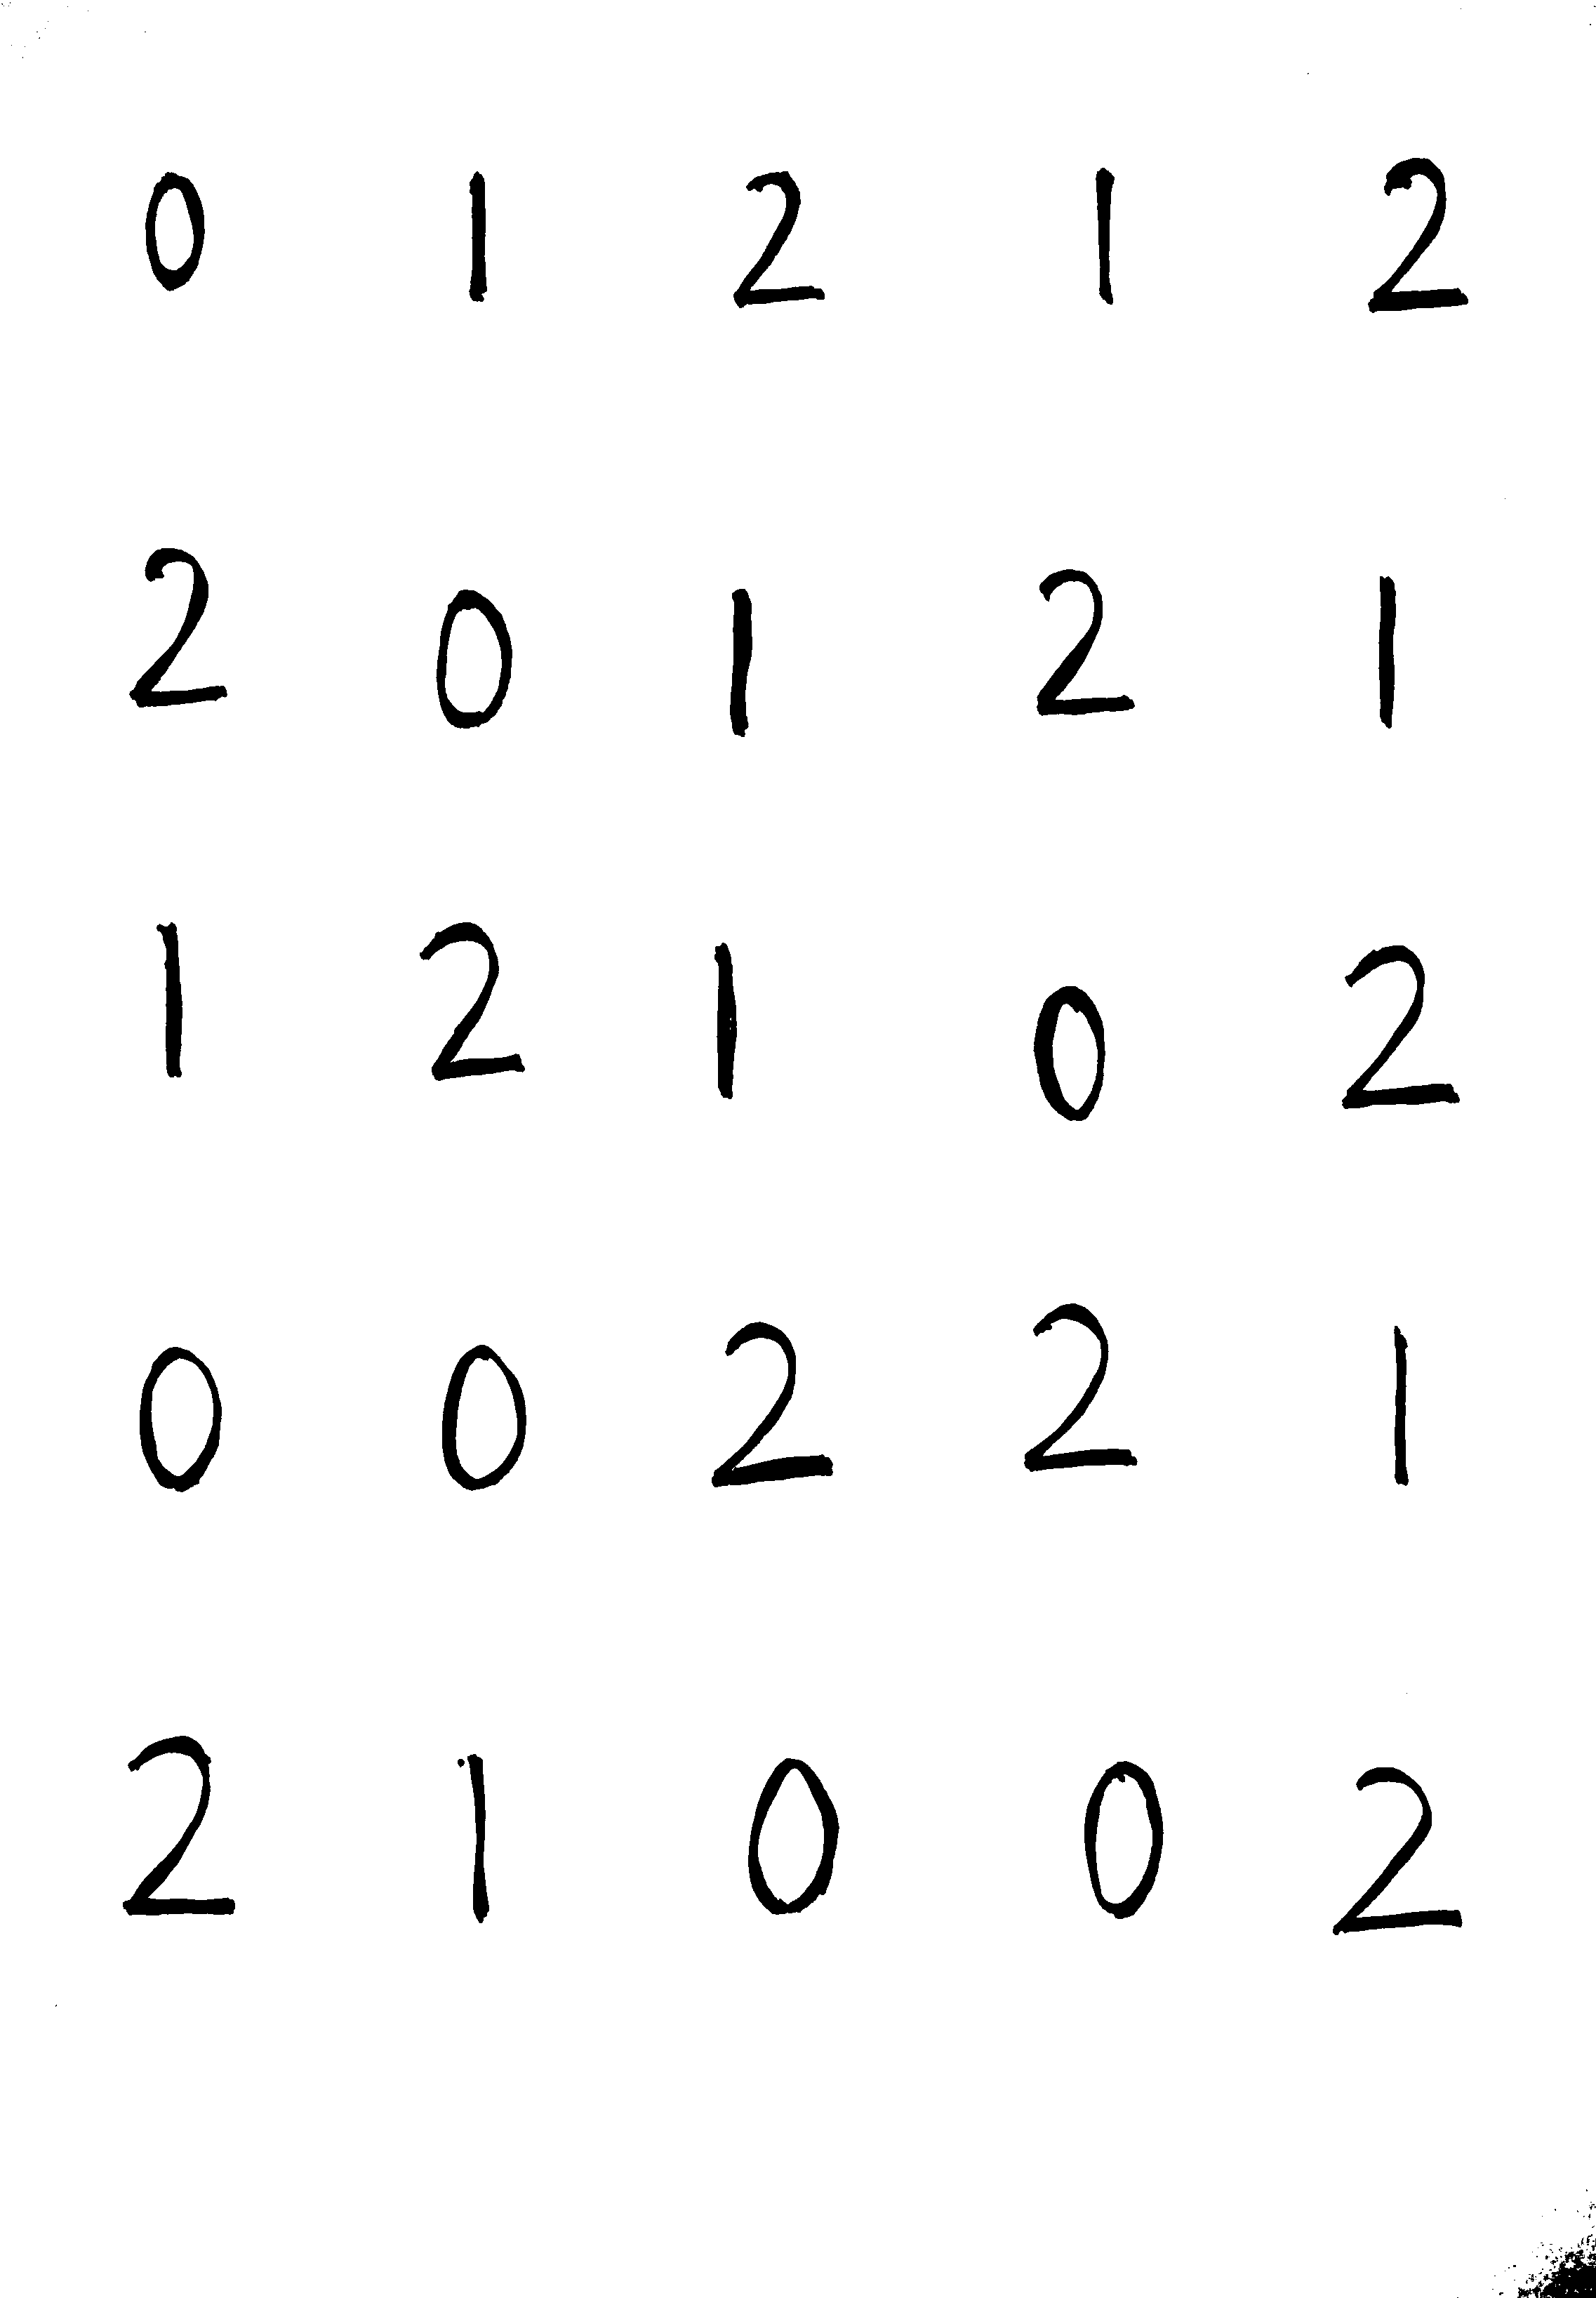

In [ ]:
thresholding_value1, thresholding_result1 = cv.threshold(image2_gray, 100, 255, cv.THRESH_BINARY)
print(thresholding_value1)
cv2_imshow(thresholding_result1)

In [ ]:
thresholding_result1 = cv.bitwise_not(thresholding_result1)

contours1, hierarchy1 = cv.findContours(thresholding_result1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

print(contours1)

[array([[[2076, 3273]],

       [[2077, 3273]]], dtype=int32), array([[[2137, 3266]],

       [[2136, 3267]],

       [[2136, 3269]],

       [[2138, 3269]],

       [[2138, 3268]],

       [[2139, 3267]],

       [[2141, 3267]],

       [[2141, 3266]]], dtype=int32), array([[[2126, 3261]],

       [[2127, 3261]]], dtype=int32), array([[[2175, 3248]],

       [[2175, 3249]],

       [[2174, 3250]],

       [[2174, 3252]],

       [[2175, 3253]],

       [[2176, 3252]],

       [[2175, 3251]],

       [[2175, 3250]],

       [[2176, 3249]]], dtype=int32), array([[[2157, 3248]],

       [[2158, 3248]]], dtype=int32), array([[[2188, 3247]]], dtype=int32), array([[[2187, 3243]],

       [[2188, 3244]],

       [[2188, 3243]]], dtype=int32), array([[[2129, 3242]],

       [[2130, 3242]]], dtype=int32), array([[[2183, 3240]],

       [[2182, 3241]],

       [[2182, 3245]],

       [[2181, 3246]],

       [[2180, 3246]],

       [[2179, 3245]],

       [[2178, 3245]],

       [[2178, 3246]],


In [ ]:
print(len(contours1))

area1 = cv.contourArea(contours1[0])
print(area1)

x, y, w, h = cv.boundingRect(contours1[0])

print(x, y, w, h)

104
0.0
2076 3273 2 1


In [ ]:
area_array = []
for index, contour1 in enumerate(contours1):
  x, y, w, h = cv.boundingRect(contour1)
  area1 = cv.contourArea(contour1)

# print("Contour ke- " + str(index), x, y, w, h, area1)
  area_array.append([index, area1, w, h])

df_area1 = pd.DataFrame(area_array)
df_area1.columns = ['index', 'area', 'width', 'height']
sort = df_area1.sort_values(by=['area'], ascending=False)
sort.head(30)


,index,area,width,height
61,61,21480.5,130,223
59,59,19146.0,113,225
66,66,18888.5,120,208
65,65,18367.0,117,207
75,75,16502.0,109,198
70,70,15023.5,103,192
81,81,10740.0,85,170
68,68,9206.0,173,236
63,63,9002.0,160,256
71,71,8802.0,168,233


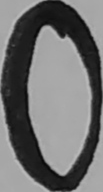

In [ ]:
x, y, w, h = cv.boundingRect(contours1[70])

testdata = image2_gray[y:y+h, x:x+w]

cv2_imshow(testdata)

In [ ]:
new_test = df_area1['area']
new_array = []
dir_save = '/content/drive/My Drive/Datasets/numbers/testing2'

for i, val in enumerate(new_test):
  if new_test[i] > 2000:
    new_array.append(i)

new_array.sort()
print(new_array)
os.chdir(dir_save)

for i, val in enumerate(new_array):
  x, y, w, h = cv.boundingRect(contours1[val])
  numb = image2[y:y+h, x:x+w]
  resized = cv.resize(numb, (h, w), interpolation = cv.INTER_AREA)
  cv.imwrite('numb{}.png'.format(i), resized)

print(os.listdir(dir_save))

[28, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85]
['numb0.png', 'numb16.png', 'numb1.png', 'numb17.png', 'numb2.png', 'numb18.png', 'numb3.png', 'numb19.png', 'numb4.png', 'numb20.png', 'numb5.png', 'numb21.png', 'numb6.png', 'numb7.png', 'numb22.png', 'numb8.png', 'numb23.png', 'numb9.png', 'numb24.png', 'numb10.png', 'numb25.png', 'numb11.png', 'numb12.png', 'numb13.png', 'numb14.png', 'numb15.png']


In [ ]:
model_train(28, 'hog', 500)

Logistic Regression
Akurasi dari Testing Set: 0.967
f1 score  0.9666545792514
precision score  0.9668412068511012
recall score  0.9666888150609081

LinearSVC
Akurasi dari Testing Set: 0.987
f1 score  0.9866866031177292
precision score  0.9867468994610977
recall score  0.9866740494647471

Random Forest Classifier
Akurasi dari Testing Set: 0.983
f1 score  0.983360917541766
precision score  0.9833953294995051
recall score  0.9833517903285345



In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=128, extraction_method='hog')
(feature_test, label_test) = load_split(testingPath, image_size=128, extraction_method='hog')
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)
testing_paths = list(paths.list_images(testingPath))
images = []
random_forest=RandomForestClassifier(n_estimators=50, random_state=10)
random_forest.fit(feature_train, label_train)

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=128)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = random_forest.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "0" else (0, 0, 255) if label == "1" else (0, 225, 225)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

In [ ]:
testing_paths = list(paths.list_images(os.path.join(dataset_dir, "testing2")))
images = []
random_forest=RandomForestClassifier(n_estimators=50, random_state=10)
random_forest.fit(feature_train, label_train)

for testing_path in testing_paths[:25]:
	image1 = cv.imread(testing_path)
	output = image1.copy()
	output = cv.resize(output, (128, 128))

	image1 = preprocess(image1, image_size=128)

	if extraction_method == 'hog':
		features = quantify_image_hog(image1)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image1)
   
	preds = random_forest.predict([features])
	label = le.inverse_transform(preds)[0]
	color = (0, 255, 0) if label == "0" else (0, 0, 255) if label == "1" else (0, 225, 225)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

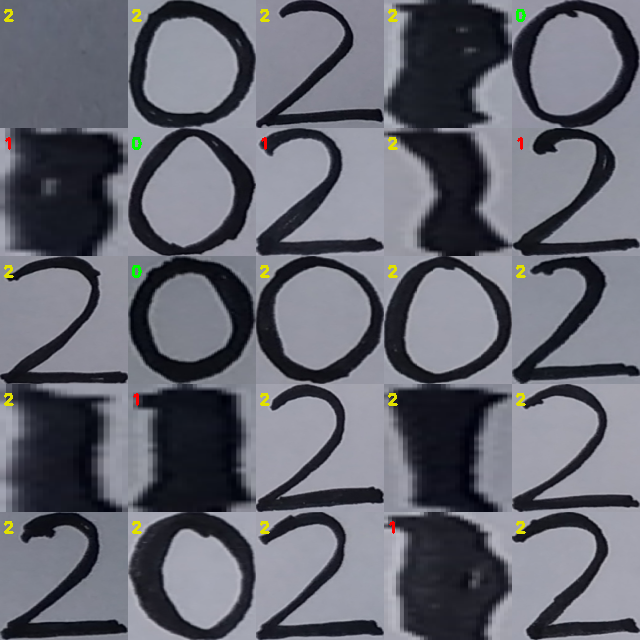

In [ ]:
montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

Untuk yang menggunakan data manual masih terdapat error, yang angka 1 nya seperti di fit ke ukuran yang di tentukan, dan banyak angka 0 terdeteksi sebagai angka 2


In [62]:
image2_asli = image2.copy()
image_height = image2.shape[0]
image_width = image2.shape[1]
image_area = image_height*image_width

cv2_imshow(image2)

Output hidden; open in https://colab.research.google.com to view.

In [64]:
def preproc(image, image_size=128, resize=True):
	image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
	
	if resize == True:
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)
	
	image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding
	
	return image

In [65]:
image2=preproc(image2, resize=False)

In [69]:
def ekstraksi_gambar(image):
  contours = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
  objects = []
  for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    objects.append({'image'  : image2_asli[y:y+h, x:x+w],
                    'left'   : x,
                    'top'    : y,
                    'right'  : x+w,
                    'bottom' : y+h})
  return objects

In [70]:
objek=ekstraksi_gambar(image2)

In [75]:
def bounding_model(objek, image_ori, model):
  for obj in objek:
    image = obj['image']
    image = preproc(image, image_size=128)
    if extraction_method == 'pxb':
      features = quantify_image_pxb(image)
    elif extraction_method == 'hog':
      features = quantify_image_hog(image)
    elif extraction_method == 'lbp':
      features = quantify_image_lbp(image)

    preds = model.predict([features])
    label = le.inverse_transform(preds)[0]
    text = str(label)
    color = (0,255,0)
    text_org = (obj['left']-5,obj['top']-10)

    cv.rectangle(image_ori,(obj['left']-5,obj['top']-5),(obj['right']+5,obj['bottom']+5),color,2)
    cv.putText(image_ori,text,text_org,cv.FONT_HERSHEY_SIMPLEX,0.5,color,2)
  
  cv2_imshow(image_ori)

In [76]:
model = SVC()
model.fit(feature_train, label_train)
bounding_model(objek, image2_asli, model)

Output hidden; open in https://colab.research.google.com to view.